In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from joblib import dump

# project paths
ROOT = Path("..")
DATA_PROCESSED = ROOT / "data" / "processed" / "db1"
DATA_OUTPUTS   = ROOT / "data" / "outputs"  / "db1"
MODELS_DIR     = ROOT / "models" / "db1"
REPORTS_DIR    = ROOT / "reports" / "db1"

for p in [DATA_OUTPUTS, MODELS_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

np.random.seed(0)

# Load features (and subjects if present)

In [2]:
X = np.load(DATA_PROCESSED / "X_feat_db1.npy")
y = np.load(DATA_PROCESSED / "y_db1.npy")

# optional subject ids (created in your featureization step)
SUBJECTS_PATH = DATA_PROCESSED / "subjects_db1.npy"
subjects = np.load(SUBJECTS_PATH) if SUBJECTS_PATH.exists() else None

print("X:", X.shape, " y:", y.shape)
if subjects is not None:
    print("subjects:", subjects.shape, " unique:", np.unique(subjects).size)
else:
    print("subjects: not found (using random sample split)")

X: (1105889, 190)  y: (1105889,)
subjects: (1105889,)  unique: 27


In [3]:
SUBJECTS_PATH = DATA_PROCESSED / "subjects_db1.npy"
if SUBJECTS_PATH.exists():
    subjects = np.load(SUBJECTS_PATH)
    print("subjects shape:", subjects.shape, "unique:", np.unique(subjects))
else:
    subjects = None
    print("No subjects array found; using random sample split.")

subjects shape: (1105889,) unique: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27]


In [4]:
if subjects is not None:
    unique_subj = sorted(np.unique(subjects))
    # example: last 2 subjects for test
    test_subjects  = set(unique_subj[-2:])
    train_subjects = set(unique_subj[:-2])
    print("Train subjects:", sorted(train_subjects))
    print("Test subjects :", sorted(test_subjects))

    tr_idx = np.isin(subjects, list(train_subjects))
    te_idx = np.isin(subjects, list(test_subjects))
    Xtr, Xte, ytr, yte = X[tr_idx], X[te_idx], y[tr_idx], y[te_idx]
    print("Train:", Xtr.shape, " Test:", Xte.shape)
else:
    Xtr, Xte, ytr, yte = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=0
    )
    print("Train:", Xtr.shape, " Test:", Xte.shape)

Train subjects: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25)]
Test subjects : [np.int32(26), np.int32(27)]
Train: (1023969, 190)  Test: (81920, 190)


In [5]:
# resample to make it faster
from sklearn.utils import resample
Xtr, ytr = resample(Xtr, ytr, n_samples=50000, stratify=ytr, random_state=0)
print("Train:", Xtr.shape, " Test:", Xte.shape)

Train: (50000, 190)  Test: (81920, 190)


# Define candidate models

In [6]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

models = {
    # Logistic Regression (good baseline, works well with lots of data)
    "LogReg": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            max_iter=500,
            n_jobs=-1,                # parallelize across CPU cores
            class_weight="balanced"   # optional: handle class imbalance
        ))
    ]),

    # Linear SVM (much faster than RBF SVM, works well on large datasets)
    "LinearSVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LinearSVC(
            max_iter=5000,
            dual=False,              # faster when n_samples > n_features
            class_weight="balanced"  # optional
        ))
    ]),

    # SGDClassifier with hinge loss (approximate linear SVM, even more scalable)
    "SGD-SVM": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SGDClassifier(
            loss="hinge",            # linear SVM
            max_iter=2000,
            tol=1e-3,
            n_jobs=-1,
            class_weight="balanced"  # optional
        ))
    ]),

    # Random Forest (handles non-linearities well, efficient in parallel)
    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        n_jobs=-1,
        random_state=0,
        class_weight="balanced"      # optional
    ),
}

models

{'LogReg': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf',
                  LogisticRegression(class_weight='balanced', max_iter=500,
                                     n_jobs=-1))]),
 'LinearSVM': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf',
                  LinearSVC(class_weight='balanced', dual=False,
                            max_iter=5000))]),
 'SGD-SVM': Pipeline(steps=[('scaler', StandardScaler()),
                 ('clf',
                  SGDClassifier(class_weight='balanced', max_iter=2000,
                                n_jobs=-1))]),
 'RandomForest': RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                        random_state=0)}

# Train, evaluate, pick best

In [7]:
best_name, best_model, best_f1 = None, None, -1.0
results = []

for name, model in models.items():
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    acc = accuracy_score(yte, pred)
    f1  = f1_score(yte, pred, average="macro")
    results.append((name, acc, f1))
    print(f"{name:10s} — acc: {acc:.3f}  f1: {f1:.3f}")
    if f1 > best_f1:
        best_name, best_model, best_f1 = name, model, f1

print("\nBest:", best_name, "F1:", round(best_f1, 4))

LogReg     — acc: 0.135  f1: 0.137
LinearSVM  — acc: 0.118  f1: 0.116
SGD-SVM    — acc: 0.084  f1: 0.075
RandomForest — acc: 0.162  f1: 0.166

Best: RandomForest F1: 0.1661


#  Save best model + text report

In [8]:
dump(best_model, MODELS_DIR / f"{best_name}_baseline.joblib")

report = classification_report(yte, best_model.predict(Xte), zero_division=0)
(DATA_OUTPUTS / "metrics.txt").write_text(
    f"Best={best_name}  F1={best_f1:.4f}\n\n{report}\n"
)

print("Saved model  ->", MODELS_DIR / f"{best_name}_baseline.joblib")
print("Saved report ->", DATA_OUTPUTS / "metrics.txt")
print(report)

Saved model  -> ../models/db1/RandomForest_baseline.joblib
Saved report -> ../data/outputs/db1/metrics.txt
              precision    recall  f1-score   support

           1       0.10      0.08      0.09      4828
           2       0.28      0.37      0.32      4333
           3       0.15      0.07      0.10      5160
           4       0.20      0.16      0.18      4518
           5       0.21      0.19      0.20      4289
           6       0.20      0.14      0.16      4549
           7       0.19      0.19      0.19      4636
           8       0.12      0.12      0.12      4779
           9       0.11      0.09      0.10      5329
          10       0.17      0.17      0.17      4569
          11       0.14      0.18      0.16      4820
          12       0.16      0.20      0.18      4638
          13       0.30      0.15      0.20      2999
          14       0.20      0.11      0.15      2862
          15       0.12      0.27      0.17      3015
          16       0.19     

# Confusion matrix figure

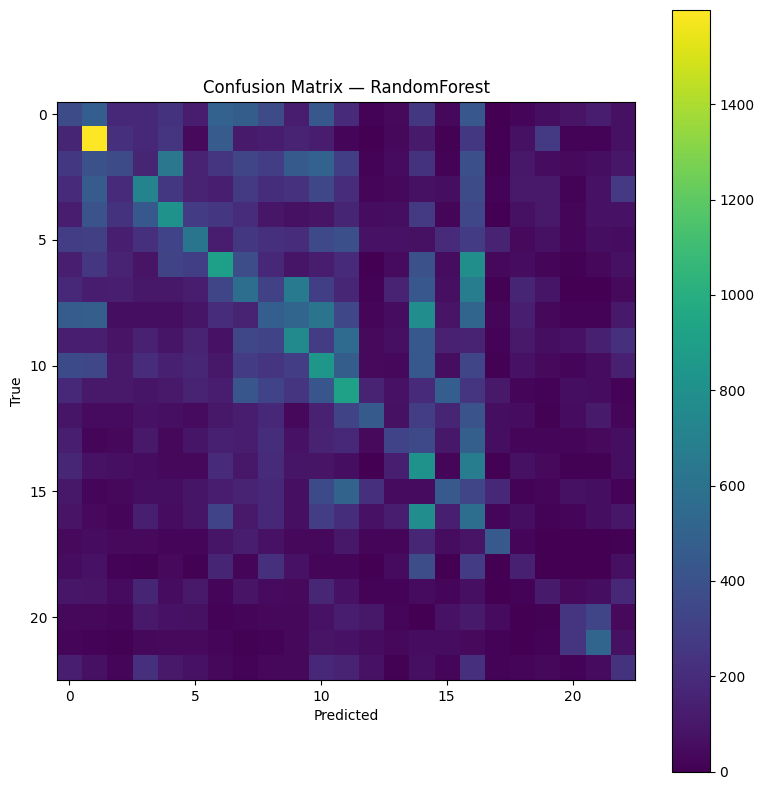

Saved: ../reports/db1/cm_RandomForest.png


In [9]:
cm = confusion_matrix(yte, best_model.predict(Xte))

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation="nearest")
ax.set_title(f"Confusion Matrix — {best_name}")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
plt.colorbar(im, ax=ax)
plt.tight_layout()

fig_path = REPORTS_DIR / f"cm_{best_name}.png"
plt.savefig(fig_path, dpi=150)
plt.show()
print("Saved:", fig_path)